In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import casadi as cas
import matplotlib.pyplot as plt

import soromox
from soromox.systems.planar_pcs import PlanarPCS
from soromox.systems.tendon_actuated_planar_pcs import TendonActuatedPlanarPCS
from soromox.systems.pendulum import Pendulum
from soromox.systems.system_state import SystemState
import diffrax

from time import perf_counter

jax.config.update("jax_enable_x64", True)

In [3]:
num_segments = 1
params = {
    "th0": jnp.array(jnp.pi / 2),  # initial orientation angle [rad]
    "L": 1e-1 * jnp.ones((num_segments,)),
    "r": 2e-2 * jnp.ones((num_segments,)),
    "rho": 1070 * jnp.ones((num_segments,)),  # Volumetric density of Dragon Skin 20 [kg/m^3],
    "g": jnp.array([0.0, 9.81]),  # gravitational acceleration [m/s^2] UP!
    "E": 5e3 * jnp.ones((num_segments,)),  # Elastic modulus [Pa]
    "G": 1e3 * jnp.ones((num_segments,)),  # Shear modulus [Pa]
    "d": 2e-2 * jnp.array([[1.0, -1.0]]).repeat(num_segments, axis=0),  # distance of tendons from the central axis [m]
}
params["D"] = 1e-3 * jnp.diag((jnp.repeat(jnp.array([[1e0, 1e3, 1e3]]), num_segments, axis=0) * params["L"][:, None]).flatten())

robot = PlanarPCS(num_segments=num_segments, params=params)

In [4]:
q0 = jnp.repeat(jnp.array([5.0 * jnp.pi, 0.2, 0.1])[None, :], num_segments, axis=0).flatten()
qd0 = jnp.zeros_like(q0)
initial_state = SystemState(t=0.0, y=jnp.concatenate([q0, qd0]))
chi_tips_initial = robot.forward_kinematics_tips(q0)

In [5]:
trajectory_rk = robot.rollout_to(initial_state=initial_state, u=None, t1=1.0, solver_dt=1e-3, save_dt=1e-2, solver=diffrax.Euler())
chi_tips_rk = []
for i in range(trajectory_rk.y.shape[0]):
    chi_tips_rk.append(robot.forward_kinematics_tips(jnp.split(trajectory_rk.y[i], 2)[0]))
chi_tips_rk = jnp.array(chi_tips_rk)
print(jnp.all(jnp.isfinite(trajectory_rk.y)))

False


(101, 1, 3) (101, 6)


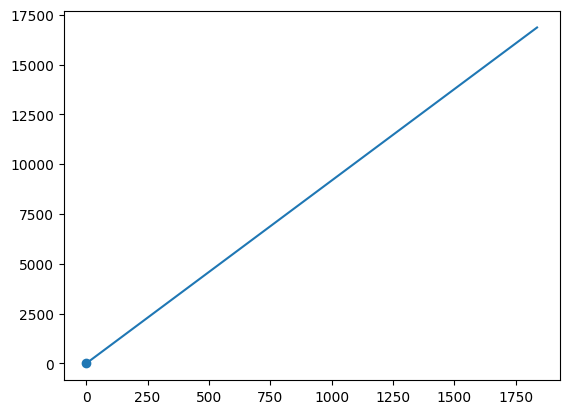

In [6]:
print(chi_tips_rk.shape, trajectory_rk.y.shape)
plt.plot(chi_tips_rk[:, -1, 1], chi_tips_rk[:, -1, 2])
plt.scatter(chi_tips_initial[-1, 1], chi_tips_initial[-1, 2])

In [7]:
f1 = lambda x, u, dt: x + dt * robot.forward_dynamics(None, x, (u,))
Jf1 = lambda x, u: jax.jacfwd(robot.forward_dynamics, argnums=1)(None, x, (u,))

def f3(x, u, dt):
    k1 = robot.forward_dynamics(None, x, (u,))
    k2 = robot.forward_dynamics(None, x + 0.5 * dt * k1, (u,))
    k3 = robot.forward_dynamics(None, x - dt * k1 + 2 * dt * k2, (u,))
    return x + (dt / 6) * (k1 + 4 * k2 + k3)

@jax.jit
def f_d(x, u, dt):
    term = diffrax.ODETerm(robot.forward_dynamics)
    solver = diffrax.Euler()
    sol = diffrax.diffeqsolve(term, solver, t0=0.0, t1=dt, dt0=1e-4, y0=x, args=(u,))
    return sol.ys[0]

@jax.jit
def Jf_d(x, u, dt):
    return jax.jacrev(f_d, argnums=0)(x, u, dt)

@jax.jit
def Jf_d_approx(x, u, dt):
    Jac_c = jax.jacrev(robot.forward_dynamics, argnums=1)(None, x, (u,))
    I = jnp.eye(x.shape[0])
    return jax.scipy.linalg.expm(dt * Jac_c)


In [8]:
dynamics_comp_time = []
jacobian_comp_time = []
approx_jacobian_comp_time = []
approx_jacobian_error = []
for _ in range(100):
    x_rand = jnp.zeros_like(initial_state.y) + np.random.rand() * initial_state.y
    tic = perf_counter()
    x_next = f_d(x_rand, None, 1e-2)
    dynamics_comp_time.append(perf_counter() - tic)
    tic = perf_counter()
    Jac = Jf_d(x_rand, None, 1e-2)
    jacobian_comp_time.append(perf_counter() - tic)
    Jac_approx = Jf_d_approx(x_rand, None, 1e-2)
    approx_jacobian_error.append(jnp.mean(jnp.abs((Jac - Jac_approx) / Jac)))
print(sum(dynamics_comp_time[1:]) / len(dynamics_comp_time[1:]), dynamics_comp_time)
print(sum(jacobian_comp_time[1:]) / len(jacobian_comp_time[1:]), jacobian_comp_time)
print(sum(approx_jacobian_error) / len(approx_jacobian_error), np.array(approx_jacobian_error).tolist())

0.02192767418190752 [1.0849125249987992, 0.0014086530027270783, 7.706199903623201e-05, 2.879699968616478e-05, 2.7890000637853518e-05, 0.02410110599885229, 0.022999584001809126, 0.023262304999661865, 0.022228628000448225, 0.024829753001540666, 0.02424449400132289, 0.02314955700057908, 0.021579862001090078, 0.023465589998522773, 0.022361179999279557, 0.02322845500020776, 0.02293615100279567, 0.02384764599992195, 0.023260549001861364, 0.023062108000885928, 0.022426062998420093, 0.023346453002886847, 0.023127379001380177, 0.023378318001050502, 0.0227802490007889, 0.02375084099912783, 0.02317103200039128, 0.02326033599820221, 0.02213812799891457, 0.023549023000668967, 0.02421655199941597, 0.02339434299938148, 0.022308281000732677, 0.024050355998042505, 0.022823303999757627, 0.021991270001308294, 0.022108281998953316, 0.024145964001945686, 0.024669965001521632, 0.022423385998990852, 0.021241455000563292, 0.024480391999532003, 0.022269068998866715, 0.02475317999778781, 0.022415803003241308, 0

In [9]:
dt_euler = 1e-2
t_euler = [initial_state.t]
x_euler = [initial_state.y]
chi_tips_euler = [chi_tips_initial]
while t_euler[-1] < 1.0:
    x_next = f_d(x_euler[-1], None, dt_euler)
    x_euler.append(x_next)
    t_euler.append(t_euler[-1] + dt_euler)
    chi_tips_euler.append(robot.forward_kinematics_tips(jnp.split(x_euler[-1], 2)[0]))
    print(jnp.linalg.norm(x_next))
trajectory_euler = SystemState(t=jnp.array(t_euler), y=jnp.array(x_euler))
q_euler = jnp.split(trajectory_euler.y, 2, axis=1)[0]
qd_euler = jnp.split(trajectory_euler.y, 2, axis=1)[1]
chi_tips_euler = jnp.array(chi_tips_euler)

23.806168
28.17696
30.0431
30.617012
30.574213
30.246881
29.792639
29.28513
28.758423
28.228142
27.701368
27.181248
26.669125
26.165504
25.670546
25.184229
24.706448
24.23709
23.776028
23.323126
22.878262
22.44132
22.012163
21.590685
21.176764
20.770288
20.371159
19.97926
19.594492
19.21676
18.84595
18.481977
18.124731
17.77412
17.430052
17.092428
16.761154
16.43614
16.117287
15.80451
15.497713
15.196808
14.901697
14.612298
14.328517
14.050269
13.777462
13.510003
13.247813
12.990802
12.738886
12.491979
12.249993
12.012845
11.78045
11.552728
11.329591
11.110966
10.896763
10.686911
10.481323
10.279923
10.082633
9.88938
9.700084
9.51467
9.333066
9.155205
8.98101
8.810407
8.64333
8.479705
8.319468
8.162552
8.00889
7.8584166
7.7110724
7.5667844
7.4255037
7.287159
7.1516943
7.01905
6.889171
6.7619967
6.6374683
6.5155377
6.396144
6.2792454
6.164774
6.052691
5.9429417
5.8354774
5.73025
5.6272116
5.5263176
5.4275165
5.3307724
5.2360353
5.1432595
5.052411


In [40]:
print(q_euler, jnp.split(trajectory_rk.y, 2, axis=1)[0])

[[1.57079630e+01 2.00000003e-01 1.00000001e-01]
 [1.57034969e+01 1.99800581e-01 1.00161895e-01]
 [1.56968784e+01 1.99341863e-01 1.00338005e-01]
 ...
 [8.40169239e+00 4.02448059e-04 2.84872279e-02]
 [8.39637852e+00 4.00246616e-04 2.84507517e-02]
 [8.39106464e+00 3.98058881e-04 2.84143146e-02]] [[15.707963    0.2         0.1       ]
 [15.636492    0.19174254  0.10039941]]


(1001, 1, 3) (1001, 6)


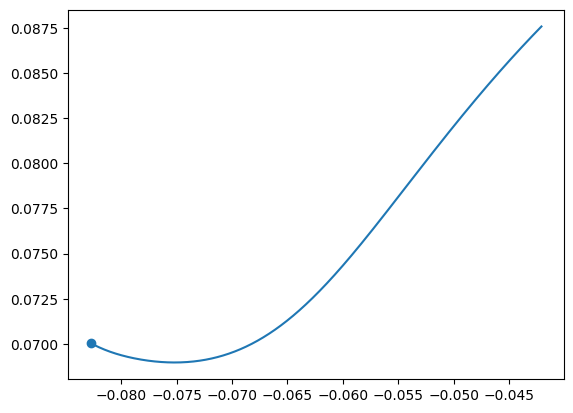

In [41]:
print(chi_tips_euler.shape, trajectory_euler.y.shape)
plt.plot(chi_tips_euler[:, -1, 1], chi_tips_euler[:, -1, 2])
plt.scatter(chi_tips_initial[-1, 1], chi_tips_initial[-1, 2])

In [7]:
def find_fucking_error(q, qd):
        Xs_scaled, Ws_scaled = jax.vmap(soromox.utils.integration.scale_gaussian_quadrature, in_axes=(None, None, 0, 0))(robot.Xs, robot.Ws, robot.L_cum[:-1], robot.L_cum[1:])

        xi = robot.strain(q).reshape(robot.num_segments, 3)
        xid = (robot.B_xi @ qd).reshape(robot.num_segments, 3)
        print(xi, xid)

        # xi_i = xi[0]
        # s_i = robot.L[0]
        # theta = jnp.abs(xi_i[0])
        # adjoint_xi_i = soromox.utils.lie_algebra.adjoint_se2(xi_i)
        # cos_theta = jnp.cos(s_i * theta)
        # sin_theta = jnp.sin(s_i * theta)
        # adjoint_xi_i_square = adjoint_xi_i @ adjoint_xi_i
        # adjoint_xi_i_cube = adjoint_xi_i_square @ adjoint_xi_i
        # adjoint_xi_i_quad = adjoint_xi_i_cube @ adjoint_xi_i
        # print(theta, theta**2, theta**3, theta**4, robot.global_eps)
        # print((3 * sin_theta - s_i * theta * cos_theta) / (2 * theta) * adjoint_xi_i)
        # print((4 - 4 * cos_theta - s_i * theta * sin_theta) / (2 * theta**2) * adjoint_xi_i_square)
        # print((sin_theta - s_i * theta * cos_theta) / (2 * theta**3) * adjoint_xi_i_cube)
        # print((2 - 2 * cos_theta - s_i * theta * sin_theta) / (2 * theta**4) * adjoint_xi_i_quad)

        Ad_inv_tips = jax.vmap(lambda xi_i, L_i: soromox.utils.lie_algebra.Adjoint_gi_se2_inv(xi_i, L_i, eps=robot.global_eps))(xi, robot.L)
        T_tips = jax.vmap(lambda xi_i, L_i: soromox.utils.lie_algebra.Tangent_gi_se2(xi_i, L_i, eps=robot.global_eps))(xi, robot.L)
        Td_tips = jax.vmap(lambda xi_i, xid_i, L_i: soromox.utils.lie_algebra.Tangent_derivative_gi_se2(xi_i, xid_i, L_i, eps=robot.global_eps))(xi, xid, robot.L)
        if jnp.isnan(Ad_inv_tips).any():
            print("NaN in Ad_inv_tips", Ad_inv_tips)
        if jnp.isnan(T_tips).any():
            print("NaN in T_tips", T_tips)
        if jnp.isnan(Td_tips).any():
            print("NaN in Td_tips", Td_tips)

        print(soromox.utils.lie_algebra.Tangent_derivative_gi_se2(xi[0], xid[0], robot.L[0], eps=robot.global_eps))

In [29]:
t_sim = [0]
q_sim = [q0]
qd_sim = [qd0]
dt = 1e-3
x = jnp.concatenate([q0.reshape(-1), qd0.reshape(-1)], axis=0)
u = np.ones((robot.actuation_matrix(q0).shape[1])) * 0.1
while t_sim[-1] < 0.1:
    x_next = x + f(x, u) * dt
    if np.isnan(x_next).any():
        print("NaN detected!")
        print(q_sim[-1], qd_sim[-1])
        find_fucking_error(q_sim[-1], qd_sim[-1])
        break
    t_sim.append(t_sim[-1] + dt)
    q_sim.append(jnp.split(x_next, 2)[0])
    qd_sim.append(jnp.split(x_next, 2)[1])
    x = x_next
    print(jnp.mean(jnp.abs(qd_sim[-1])) + jnp.mean(jnp.abs(q_sim[-1])))
t_sim = jnp.array(t_sim)
q_sim = jnp.array(q_sim)
qd_sim = jnp.array(qd_sim)

30.413076
76.19401
421.40408
2041.8024
10527.679
61364.934
2239807.8
12542176000.0
3.5106898e+17
inf
NaN detected!
[ 4.0380801e+12  2.1885638e+14 -1.5544738e+14  5.0162560e+09
  8.7243167e+14  1.6840212e+15  4.1758068e+11  2.9915796e+14
  1.4400431e+15 -1.1318594e+12 -2.7428955e+14  1.8707384e+14
 -9.6602718e+11  2.6274886e+13 -1.0187973e+14] [-8.7952169e+27           -inf  9.3652338e+32  2.0079143e+25
           -inf            inf -7.0193712e+25           -inf
           -inf -7.3889097e+27           -inf           -inf
  1.1355528e+28           -inf            inf]
[[ 4.0380801e+12  2.1885638e+14 -1.5544738e+14]
 [ 5.0162560e+09  8.7243167e+14  1.6840212e+15]
 [ 4.1758068e+11  2.9915796e+14  1.4400431e+15]
 [-1.1318594e+12 -2.7428955e+14  1.8707384e+14]
 [-9.6602718e+11  2.6274886e+13 -1.0187973e+14]] [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
NaN in Ad_inv_tips [[[ 1.  0.  0.]
  [nan nan nan]
  [nan nan nan]]

 [[ 1.  0.  0.]
  [nan nan  0.]
  [nan 

In [9]:
print(q_sim)

[[-1.57079639e+01 -1.78539813e+00  7.85398245e-01  0.00000000e+00
  -2.00000000e+00  0.00000000e+00]
 [-1.57079639e+01 -1.78539813e+00  7.85398245e-01  0.00000000e+00
  -2.00000000e+00  0.00000000e+00]
 [-1.57058458e+01 -1.78530777e+00  7.85472453e-01 -1.60282594e-03
  -1.99994445e+00  1.53415545e-04]
 [-1.57025204e+01 -1.78516281e+00  7.85598278e-01 -4.85243602e-03
  -1.99984050e+00  3.51468741e-04]
 [-1.56970444e+01 -1.78493011e+00  7.85791993e-01 -1.43026002e-02
  -1.99968648e+00  8.01946037e-04]
 [-1.56918755e+01 -1.78462970e+00  7.86072254e-01 -3.47446948e-02
  -1.99949610e+00  7.93512387e-04]
 [-1.56867208e+01 -1.78433919e+00  7.86355376e-01 -5.05034402e-02
  -1.99927068e+00  9.75391886e-04]
 [-1.56815844e+01 -1.78405082e+00  7.86648035e-01 -6.52502850e-02
  -1.99901187e+00  1.18205568e-03]
 [-1.56765022e+01 -1.78376496e+00  7.86949277e-01 -7.93125182e-02
  -1.99872172e+00  1.39483181e-03]
 [-1.56714687e+01 -1.78348088e+00  7.87258744e-01 -9.28450823e-02
  -1.99840188e+00  1.6085

In [10]:
find_fucking_error(q_sim[-1], qd_sim[-1])

[[-1.5197009e+01 -7.3923576e-01  8.2385945e-01]
 [-5.9411508e-01 -9.2654991e-01  1.1076220e-02]] [[ 54.03226      6.683844     3.4332497 ]
 [-16.1683       9.298509     0.38705975]]
[[ 0.          0.          0.        ]
 [-0.00070339  0.2154933  -0.13307281]
 [-0.02580748  0.13307281  0.2154933 ]]


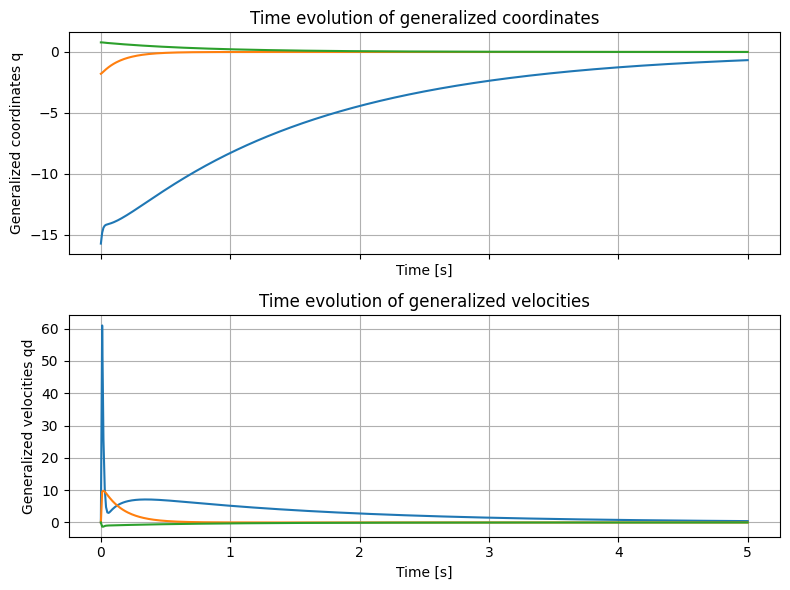

In [104]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
ax[0].plot(t_sim, q_sim)
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Generalized coordinates q')
ax[0].set_title('Time evolution of generalized coordinates')
ax[0].grid()
ax[1].plot(t_sim, qd_sim)
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Generalized velocities qd')
ax[1].set_title('Time evolution of generalized velocities')
ax[1].grid()
plt.tight_layout()
plt.show()


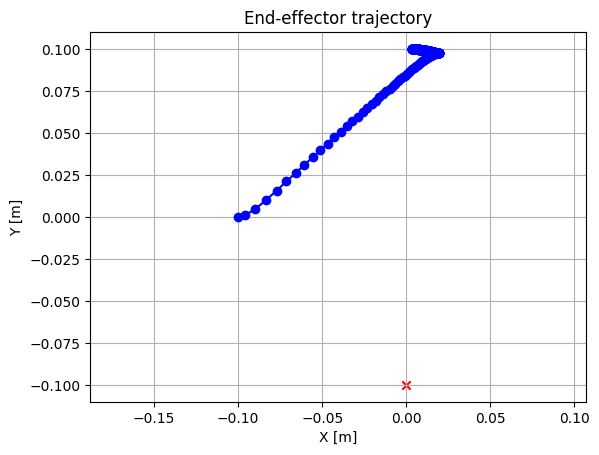

In [105]:
chi_sim = []
for q in q_sim:
    chi_sim.append(robot.forward_kinematics_tips(q))
chi_sim = np.array(chi_sim)

plt.plot(chi_sim[:, :, 1], chi_sim[:, :, 2], marker='o', c='b')
plt.scatter(0.0, -1e-1, marker='x', color='red', label='Target')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('End-effector trajectory')
plt.axis('equal')
plt.grid()
plt.show()

In [56]:
print(chi_sim[:, -1, :])

[[ 1.5707964e+00 -1.3113417e-08  3.0000001e-01]
 [ 1.5707964e+00 -1.3113417e-08  3.0000001e-01]
 [ 1.5707964e+00 -1.3113417e-08  3.0000001e-01]
 [ 1.5707964e+00 -1.3113417e-08  3.0000001e-01]
 [ 1.5707964e+00 -1.3113417e-08  3.0000001e-01]
 [ 1.5707964e+00 -1.3113417e-08  3.0000001e-01]
 [ 1.5707964e+00 -1.3113417e-08  3.0000001e-01]
 [ 1.5707964e+00 -1.3113417e-08  3.0000001e-01]
 [ 1.5707964e+00 -1.3113417e-08  3.0000001e-01]
 [ 1.5707964e+00 -1.3113417e-08  3.0000001e-01]
 [ 1.5707964e+00 -1.3113417e-08  3.0000001e-01]
 [ 1.5707964e+00 -1.3113417e-08  3.0000001e-01]
 [ 1.5707964e+00 -1.3113417e-08  3.0000001e-01]
 [ 1.5707964e+00 -1.3113417e-08  3.0000001e-01]
 [ 1.5707964e+00 -1.3113417e-08  3.0000001e-01]
 [ 1.5707964e+00 -1.3113417e-08  3.0000001e-01]
 [ 1.5707964e+00 -1.3113417e-08  3.0000001e-01]
 [ 1.5707964e+00 -1.3113417e-08  3.0000001e-01]
 [ 1.5707964e+00 -1.3113417e-08  3.0000001e-01]
 [ 1.5707964e+00 -1.3113417e-08  3.0000001e-01]
 [ 1.5707964e+00 -1.3113417e-08  3.00000

In [ ]:
plt.plot(t_sim, q_sim)
plt.xlabel('Time [s]')
plt.ylabel('Generalized coordinates q')
plt.title('Time evolution of generalized coordinates')
plt.grid()
plt.show()

In [ ]:
dt = 1e-2

f = lambda x, u: x + dt * robot.forward_dynamics(None, x, (u,))
J_f_x = jax.jacfwd(f, argnums=0)
J_f_u = jax.jacfwd(f, argnums=1)

print(f(x, u))
print(J_f_x(x, u))
print(J_f_u(x, u))

[0. 0. 0. 0. 0. 0.]
[[ 1.0000000e+00  0.0000000e+00  0.0000000e+00  9.9999998e-03
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  1.0000000e+00  0.0000000e+00  0.0000000e+00
   9.9999998e-03  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  1.0000000e+00  0.0000000e+00
   0.0000000e+00  9.9999998e-03]
 [-7.2354426e+00  0.0000000e+00  5.4265826e+02 -1.0515565e+01
   0.0000000e+00  4.3183371e+02]
 [ 0.0000000e+00 -1.4018690e+01  0.0000000e+00  0.0000000e+00
  -1.2311440e+00  0.0000000e+00]
 [ 2.7132910e-01  0.0000000e+00 -2.3153419e+01  4.3183371e-01
   0.0000000e+00 -1.7424906e+01]]
[[   0.          0.      ]
 [   0.          0.      ]
 [   0.          0.      ]
 [ 230.31131  -230.31131 ]
 [   2.231144    2.231144]
 [  -8.636674    8.636674]]


In [41]:
params = {
    "L": jnp.array([0.5, 0.3]),      # Link lengths [m]
    "Lc": jnp.array([0.25, 0.15]),   # Center of mass positions [m]
    "m": jnp.array([1.0, 0.5]),      # Masses [kg]
    "I": jnp.array([0.1, 0.05]),     # Moments of inertia [kg⋅m²]
    "g": jnp.array([0.0, -9.81]),    # Planar gravity vector [m/s²]
}

pendulum = Pendulum(params=params)

q0 = jnp.array([jnp.pi / 4, jnp.pi / 4])
qd0 = jnp.array([0.0, 0.0])

print(pendulum.forward_dynamics(None, jnp.hstack([q0, qd0])))

[  0.         0.       -12.565588  18.005514]


In [ ]:
trajectory_pendulum = pendulum.rollout_to(
    initial_state=SystemState(t=0.0, y=jnp.hstack([q0, qd0])),
    u=None,
    t1=10.0,
    solver_dt=1e-2,
    save_dt=1e-2,
    solver=diffrax.Euler()
)
if jnp.any(jnp.isnan(trajectory_pendulum.y)):
    print("NaN detected in pendulum trajectory!")
